In [1]:
%matplotlib inline

import os
import h5py
import numpy as np
from matplotlib import pyplot as plt


The fastMRI dataset is distributed as a set of HDF5 files and can be read with the h5py package. Here, we show how to open a file from the multi-coil dataset. Each file corresponds to one MRI scan and contains the k-space data, ground truth and some meta data related to the scan.

In [2]:
download_path = '/usr/local/micapollo01/MIC/DATA/SHARED/NYU_FastMRI/Preprocessed'
dicom_path = os.path.join(download_path,'fastMRI_brain_DICOM')
train_path = os.path.join(download_path,'multicoil_train')
validation_path = os.path.join(download_path,'multicoil_val')
test_path = os.path.join(download_path,'multicoil_test')
fully_sampled_test_path = os.path.join(download_path,'multicoil_test_full')


In [3]:
file_name = 'file_brain_AXFLAIR_210_6001949.h5'
hf = h5py.File(os.path.join(fully_sampled_test_path, file_name),'r')


In [4]:
GT = hf['reconstruction_rss']
GT = np.array(GT)
vmin = np.percentile(GT[3], 1)
vmax = np.percentile(GT[3], 99)


In [6]:
from fastmri.data import transforms as T

kspace = hf['kspace'][()]
kspace_torch = T.to_tensor(kspace)


In [7]:
from fastmri.data.subsample import create_mask_for_mask_type

mask_func = create_mask_for_mask_type('equispaced', [0.08], [3])
masked_kspace, mask, _ = T.apply_mask(kspace_torch, mask_func)


In [8]:
# Now, let's apply grappa

from pygrappa import grappa
import torch

def to_tensor(data: np.ndarray) -> torch.Tensor:
    """
    Convert numpy array to PyTorch tensor.

    For complex arrays, the real and imaginary parts are stacked along the last
    dimension.

    Args:
        data: Input numpy array.

    Returns:
        PyTorch version of data.
    """
    if np.iscomplexobj(data):
        data = np.stack((data.real, data.imag), axis=-1)

    return torch.from_numpy(data)

def tensor_to_complex_np(data: torch.Tensor) -> np.ndarray:
    """
    Converts a complex torch tensor to numpy array.

    Args:
        data: Input data to be converted to numpy.

    Returns:
        Complex numpy version of data.
    """
    return torch.view_as_complex(data).numpy()

def apply_grappa(masked_kspace, mask):
    """
    Applies GRAPPA algorithm
    References
    ----------
    [1] Griswold, Mark A., et al. "Generalized autocalibrating
       partially parallel acquisitions (GRAPPA)." Magnetic
       Resonance in Medicine: An Official Journal of the
       International Society for Magnetic Resonance in Medicine
       47.6 (2002): 1202-1210.
    Args:
        masked_kspace (torch.Tensor): Multi-coil masked input k-space of shape (num_coils, rows, cols, 2)
        mask (torch.Tensor): Applied mask of shape (1, 1, cols, 1)
    Returns:
        preprocessed_masked_kspace (torch.Tensor): Output of GRAPPA algorithm applied on masked_kspace
    """

    def get_low_frequency_lines(mask):
        l = r = mask.shape[-2] // 2
        while mask[..., r, :]:
            r += 1

        while mask[..., l, :]:
            l -= 1

        return l + 1, r

    l, r = get_low_frequency_lines(mask)
    num_low_freqs = r - l
    pad = (mask.shape[-2] - num_low_freqs + 1) // 2
    calib = masked_kspace[:, :, pad:pad + num_low_freqs].clone()
    preprocessed_masked_kspace = grappa(tensor_to_complex_np(masked_kspace), tensor_to_complex_np(calib), kernel_size=(5, 5), coil_axis=0)
    return to_tensor(preprocessed_masked_kspace)


# Needs to be applied slice-wise
grappa_data = torch.zeros([masked_kspace.shape[0],masked_kspace.shape[1],masked_kspace.shape[2],masked_kspace.shape[3],masked_kspace.shape[4]])
for slice in range(masked_kspace.shape[0]):
    grappa_data[slice,:,:,:,:] = apply_grappa(masked_kspace[slice,:,:,:,:], mask[0,:,:,:,:])


In [9]:
grappa_data_np = tensor_to_complex_np(grappa_data)


Here, we can visualize the results of our GRAPPA preprocessing in the image domain

In [10]:
slice_grappa = grappa_data[3,:,:,:,:]


In [11]:
import fastmri
slice_zf_image_T = fastmri.ifft2c(masked_kspace[3])
slice_zf_image_abs = fastmri.complex_abs(slice_zf_image_T)
slice_zf_image_rss = fastmri.rss(slice_zf_image_abs, dim=0)


In [12]:
def comp_img(img,crop_size):
    s = img.shape
    start_height = s[0]//2 - (crop_size[0]//2)
    start_width = s[1]//2 - (crop_size[1]//2)
    return img[start_height:(start_height+crop_size[0]),start_width:(start_width+crop_size[1])]

dim1 = GT.shape[1]
dim2 = GT.shape[2]
slice_zf_image_rss = comp_img(slice_zf_image_rss.numpy(),(dim1,dim2))


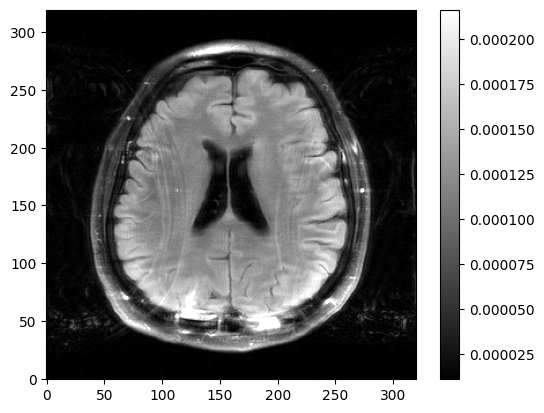

In [12]:
# R = 2
plt.imshow(np.abs(slice_zf_image_rss), cmap='gray', origin='lower', vmin=vmin, vmax=vmax)
plt.colorbar()


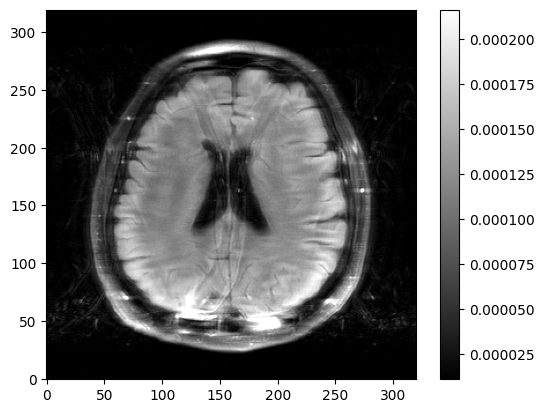

In [13]:
# R = 3
plt.imshow(np.abs(slice_zf_image_rss), cmap='gray', origin='lower', vmin=vmin, vmax=vmax)
plt.colorbar()


In [14]:
slice_grappa_image_T = fastmri.ifft2c(slice_grappa)
slice_grappa_image_abs = fastmri.complex_abs(slice_grappa_image_T)
slice_grappa_image_rss = fastmri.rss(slice_grappa_image_abs, dim=0)
slice_grappa_image_rss = comp_img(slice_grappa_image_rss.numpy(),(dim1,dim2))


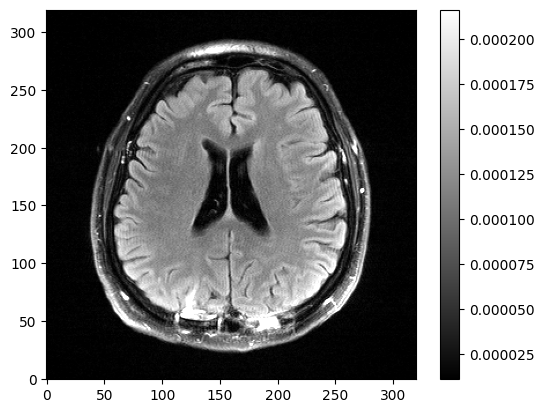

In [14]:
# R = 2
plt.imshow(np.abs(slice_grappa_image_rss), cmap='gray', origin='lower', vmin=vmin, vmax=vmax)
plt.colorbar()


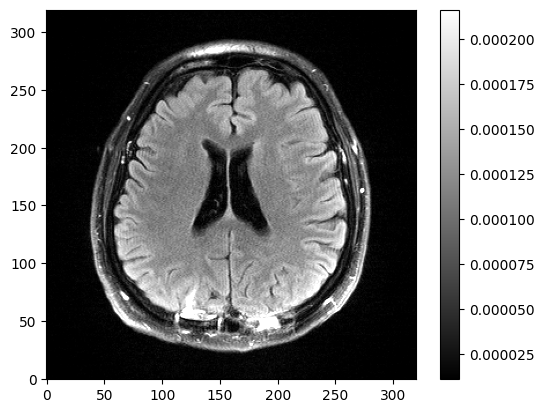

In [15]:
# R = 3
plt.imshow(np.abs(slice_grappa_image_rss), cmap='gray', origin='lower', vmin=vmin, vmax=vmax)
plt.colorbar()
